<a href="https://colab.research.google.com/github/yadavankush2404/Sales_forecasting-ARIMA-vs-LSTM-Anomaly_detection/blob/main/Sales_Forecasting_ARIMA_vs_LSTM_Hyperparam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import os
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [6]:
# Create sample sales database if not exists
if not os.path.exists("sales_data.db"):
    df_sample = pd.DataFrame({
        "date": pd.date_range(start='2022-01-01', periods=10, freq='D'),
        "sales": [20, 22, 18, 24, 19, 23, 25, 27, 29, 30]
    })
    conn = sqlite3.connect("sales_data.db")
    df_sample.to_sql("sales", conn, if_exists="replace", index=False)
    conn.close()


In [8]:
# Load data from SQLite
conn = sqlite3.connect("sales_data.db")
df = pd.read_sql("SELECT date, sales FROM sales ORDER BY date", conn, parse_dates=["date"])
df.set_index("date", inplace=True)
conn.close()

df = df.sort_index()
sales = df['sales'].values.reshape(-1, 1)


In [10]:
df.head()

,sales
date,
2022-01-01,20
2022-01-02,22
2022-01-03,18
2022-01-04,24
2022-01-05,19


In [11]:
# ARIMA Forecast
arima_model = ARIMA(df['sales'], order=(2,1,2))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=5)
arima_plot_index = pd.date_range(start=df.index[-1], periods=6, freq='D')[1:]
arima_mse = mean_squared_error(df['sales'][-5:], arima_forecast)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [12]:
# LSTM preparation
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(sales)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


In [13]:
# Hyperparameter tuning for LSTM
def evaluate_lstm(seq_len, lstm_units, epochs):
    X, y = create_sequences(scaled_sales, seq_len)
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = Sequential([
        LSTM(lstm_units, activation='relu', input_shape=(seq_len, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, verbose=0)

    lstm_pred_scaled = model.predict(X_test)
    lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
    actual = scaler.inverse_transform(y_test)

    mse = mean_squared_error(actual, lstm_pred)
    return mse, model, lstm_pred, actual

# Configurations to try
configs = [(3, 50, 100), (4, 40, 80), (5, 30, 60)]
results = []

for seq_len, units, epochs in configs:
    mse, model, pred, act = evaluate_lstm(seq_len, units, epochs)
    results.append({
        'seq_len': seq_len,
        'units': units,
        'epochs': epochs,
        'mse': mse,
        'pred': pred,
        'actual': act
    })

# Best configuration
best_result = min(results, key=lambda x: x['mse'])
print(f"Best LSTM Config → seq_len={best_result['seq_len']}, units={best_result['units']}, epochs={best_result['epochs']}, MSE={best_result['mse']:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Best LSTM Config → seq_len=5, units=30, epochs=60, MSE=5.60


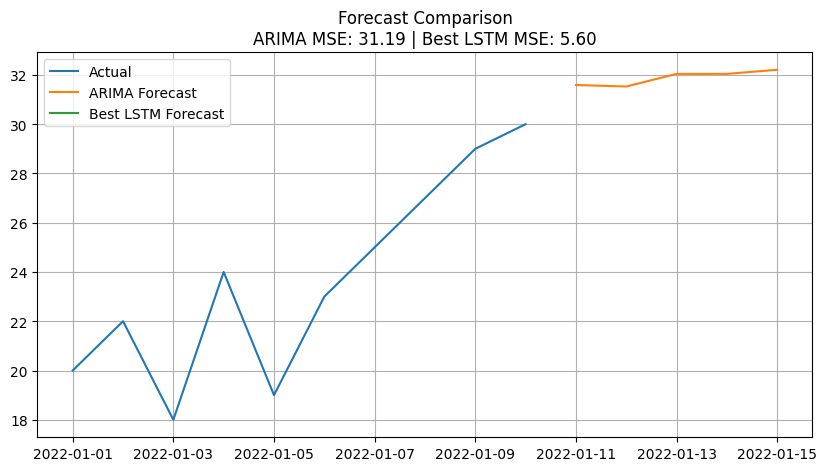

In [14]:
# Plot best LSTM vs ARIMA
plt.figure(figsize=(10, 5))
plt.plot(df.index[-10:], df['sales'][-10:], label='Actual')
plt.plot(arima_plot_index, arima_forecast, label='ARIMA Forecast')
plt.plot(df.index[-len(best_result["actual"]):], best_result["pred"], label='Best LSTM Forecast')
plt.title(f"Forecast Comparison\nARIMA MSE: {arima_mse:.2f} | Best LSTM MSE: {best_result['mse']:.2f}")
plt.legend()
plt.grid(True)
plt.show()
